In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

In [2]:
EXAMPLES_PER_CLASS = 100
USELESS_FEATURES = 1

train_data = []
train_labels = []

for _ in range(EXAMPLES_PER_CLASS):
    train_data.append([0., 0., np.random.random()])
    train_labels.append(0)

    train_data.append([0., 1., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 0., np.random.random()])
    train_labels.append(1)

    train_data.append([1., 1., np.random.random()])
    train_labels.append(0)

train_data, train_labels = torch.tensor(train_data), torch.tensor(train_labels)

test_data = []
test_labels = []

for _ in range(EXAMPLES_PER_CLASS//5):
    test_data.append([0., 0., np.random.random()])
    test_labels.append(0.)

    test_data.append([0., 1., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 0., np.random.random()])
    test_labels.append(1.)

    test_data.append([1., 1., np.random.random()])
    test_labels.append(0.)

test_data, test_labels = torch.tensor(test_data), torch.tensor(test_labels)

In [3]:
torch.manual_seed(0)
hidden = 10
model = nn.Sequential(
    nn.Linear(2+USELESS_FEATURES, hidden),
    nn.ReLU(),
    nn.Linear(hidden, 2)
)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return correct / len(y_pred) * 100

In [4]:
epochs = 1000
for epoch in range(epochs):
    y_logits = model(train_data).squeeze()
    y_preds = torch.argmax(y_logits, dim=1)
    
    loss = loss_fn(y_logits, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    if epoch % (epochs//10) == 0:
        with torch.inference_mode():
            y_logits = model(test_data).squeeze()
            y_preds = torch.argmax(y_logits, dim=1)
            acc = accuracy_fn(test_labels, y_preds)
            print(f"[EPOCH {epoch+1}/{epochs}] Loss: {loss} | Accuracy: {acc}")

[EPOCH 1/1000] Loss: 0.7108622789382935 | Accuracy: 50.0
[EPOCH 101/1000] Loss: 0.6122797727584839 | Accuracy: 100.0
[EPOCH 201/1000] Loss: 0.4644233286380768 | Accuracy: 75.0
[EPOCH 301/1000] Loss: 0.2967398166656494 | Accuracy: 100.0
[EPOCH 401/1000] Loss: 0.1492609679698944 | Accuracy: 100.0
[EPOCH 501/1000] Loss: 0.07965633273124695 | Accuracy: 100.0
[EPOCH 601/1000] Loss: 0.04868002235889435 | Accuracy: 100.0
[EPOCH 701/1000] Loss: 0.0332392081618309 | Accuracy: 100.0
[EPOCH 801/1000] Loss: 0.024395160377025604 | Accuracy: 100.0
[EPOCH 901/1000] Loss: 0.01891418546438217 | Accuracy: 100.0


(-0.10000000149011612, 1.100000023841858)

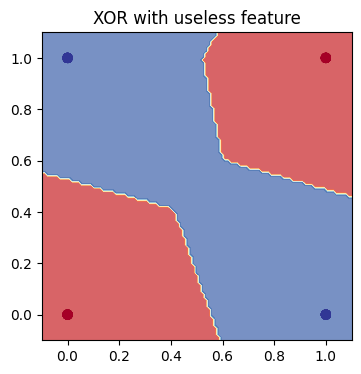

In [5]:
plt.figure(figsize=(4, 4))
plt.title("XOR with useless feature")

x_min, x_max = test_data[:, 0].min() - 0.1, test_data[:, 0].max() + 0.1
y_min, y_max = test_data[:, 1].min() - 0.1, test_data[:, 1].max() + 0.1
z_min, z_max = test_data[:, 2].min() - 0.1, test_data[:, 2].max() + 0.1
xx, yy, zz = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101), np.linspace(z_min, z_max, 101))

# Make features
X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel(), zz.ravel()))).float()

# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_to_pred_on)

# Test for multi-class or binary and adjust logits to prediction labels
y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class

# Reshape preds and plot
y_pred = y_pred.reshape(xx.shape).detach().numpy()
plt.contourf(xx[:,:,0], yy[:,:,0], y_pred[:,:,0], cmap=plt.cm.RdYlBu, alpha=0.7)
plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, s=40, cmap=plt.cm.RdYlBu)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

In [6]:
X = test_data.detach().numpy()
T = test_labels.detach().numpy()

In [7]:
# Extract weights and biases of trained MLP
layers = list(filter(None, [layer if isinstance(layer, nn.Linear) else None for layer in model.children()]))
W = [layer.weight.to('cpu').detach().numpy().T for layer in layers]
B = [layer.bias.to('cpu').detach().numpy().T for layer in layers]
L = len(W)
L, W[0].shape, W[1].shape

(2, (3, 10), (10, 2))

In [8]:
# Forward pass
A = [X] + [None] * L
for l in range(L):
    A[l+1] = np.maximum(0, A[l].dot(W[l])+B[l])

In [9]:
i = np.random.randint(0, len(X))
prediction = np.argmax(A[L][i])
print(f"Point: {X[i]}, Pred: {prediction} | Label: {T[i]}")

Point: [1.         1.         0.95005715], Pred: 0 | Label: 0.0


In [10]:
nb_labels = len(np.unique(T))
R = [None] * L + [A[L] * (T[:,None]==np.arange(nb_labels))]
#R = [None] * L + [A[L]]

In [11]:
def rho(w, l):  
    return w + [None,0.1,0.0][l] * np.maximum(0,w)
def incr(z, l): 
    return z + [None,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [12]:
# All layers except the pixels one
for l in range(1, L)[::-1]:
    w = rho(W[l], l)
    b = rho(B[l], l)

    z = incr(A[l].dot(w)+b, l)
    s = R[l+1] / z
    c = s.dot(w.T)
    R[l] = A[l] * c

In [13]:
w = W[0]
wp = np.maximum(0, w)
wm = np.minimum(0, w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9
s = R[1]/z
c, cp, cm = s.dot(w.T), s.dot(wp.T), s.dot(wm.T)
R[0] = A[0]*c - lb*cp - hb*cm

In [14]:
R[0].shape, R[1].shape, R[2].shape

((80, 3), (80, 10), (80, 2))

In [15]:
for i in range(8):
    print(f"P: {X[i].tolist()} | Label: {X[i]} | Relevance: {R[0][i]}")

P: [0.0, 0.0, 0.8131486177444458] | Label: [0.        0.        0.8131486] | Relevance: [ 2.0551894   0.4404592  -0.45893312]
P: [0.0, 1.0, 0.8723402619361877] | Label: [0.         1.         0.87234026] | Relevance: [0.7610956  1.1476121  0.06640115]
P: [1.0, 0.0, 0.3093504309654236] | Label: [1.         0.         0.30935043] | Relevance: [-0.54393446  2.0268905   0.2864623 ]
P: [1.0, 1.0, 0.5238924026489258] | Label: [1.        1.        0.5238924] | Relevance: [0.7434559  0.8148401  0.14410086]
P: [0.0, 0.0, 0.9186616539955139] | Label: [0.         0.         0.91866165] | Relevance: [ 2.0527897   0.44247258 -0.4810206 ]
P: [0.0, 1.0, 0.8525941371917725] | Label: [0.         1.         0.85259414] | Relevance: [0.7613928  1.1504579  0.06431386]
P: [1.0, 0.0, 0.96039879322052] | Label: [1.        0.        0.9603988] | Relevance: [-0.5977299   2.0029855   0.38255244]
P: [1.0, 1.0, 0.23705118894577026] | Label: [1.         1.         0.23705119] | Relevance: [0.7350928  0.8062046  0.

    [Layer 0] [ 2.0551894   0.4404592  -0.45893312]
    [Layer 1] [-0.0000000e+00 -2.6044214e+00 -1.1692735e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  5.7063282e-01
 -1.3313718e-01  4.2048106e+00]
    [Layer 2] [2.2354522 0.       ]


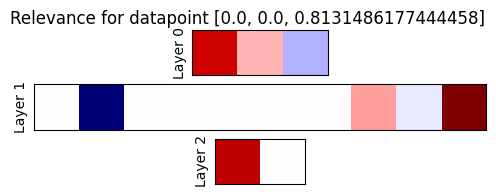

    [Layer 0] [ 2.0551894   0.4404592  -0.45893312]
    [Layer 1] [-0.0000000e+00 -2.6044214e+00 -1.1692735e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  5.7063282e-01
 -1.3313718e-01  4.2048106e+00]
    [Layer 2] [2.2354522 0.       ]


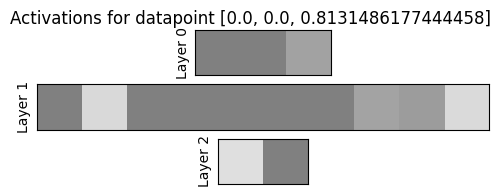

    [Layer 0] [0.7610956  1.1476121  0.06640115]
    [Layer 1] [ 0.          0.5957465   2.7511013   0.          0.         -0.04565137
  0.         -1.2808759  -0.04214129 -0.00307012]
    [Layer 2] [0.        2.3502269]


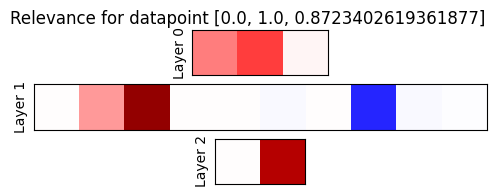

    [Layer 0] [0.7610956  1.1476121  0.06640115]
    [Layer 1] [ 0.          0.5957465   2.7511013   0.          0.         -0.04565137
  0.         -1.2808759  -0.04214129 -0.00307012]
    [Layer 2] [0.        2.3502269]


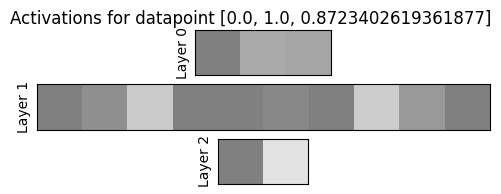

    [Layer 0] [-0.54393446  2.0268905   0.2864623 ]
    [Layer 1] [ 0.          2.8245115   0.          0.          0.         -0.
  0.         -1.037638   -0.01745529 -0.        ]
    [Layer 2] [0.       2.145314]


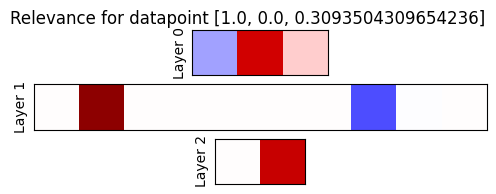

    [Layer 0] [-0.54393446  2.0268905   0.2864623 ]
    [Layer 1] [ 0.          2.8245115   0.          0.          0.         -0.
  0.         -1.037638   -0.01745529 -0.        ]
    [Layer 2] [0.       2.145314]


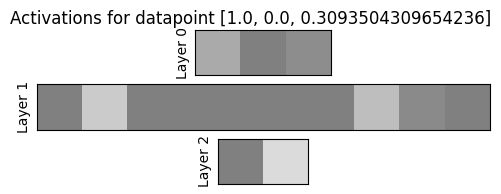

    [Layer 0] [0.7434559  0.8148401  0.14410086]
    [Layer 1] [-0.0000000e+00 -1.0437050e-01 -9.1764465e-04 -0.0000000e+00
 -0.0000000e+00 -1.1138306e-02  0.0000000e+00  1.8764483e+00
 -5.7624869e-02  0.0000000e+00]
    [Layer 2] [1.9238182 0.       ]


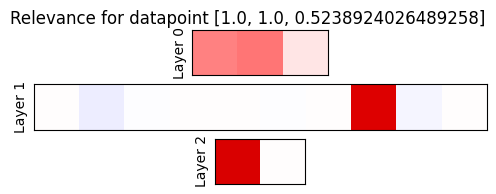

    [Layer 0] [0.7434559  0.8148401  0.14410086]
    [Layer 1] [-0.0000000e+00 -1.0437050e-01 -9.1764465e-04 -0.0000000e+00
 -0.0000000e+00 -1.1138306e-02  0.0000000e+00  1.8764483e+00
 -5.7624869e-02  0.0000000e+00]
    [Layer 2] [1.9238182 0.       ]


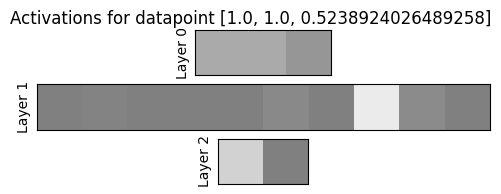

    [Layer 0] [ 2.0527897   0.44247258 -0.4810206 ]
    [Layer 1] [-0.0000000e+00 -2.6304512e+00 -1.1836638e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  6.0113937e-01
 -1.4325330e-01  4.1879907e+00]
    [Layer 2] [2.2121408 0.       ]


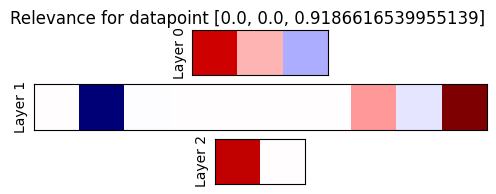

    [Layer 0] [ 2.0527897   0.44247258 -0.4810206 ]
    [Layer 1] [-0.0000000e+00 -2.6304512e+00 -1.1836638e-03 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  6.0113937e-01
 -1.4325330e-01  4.1879907e+00]
    [Layer 2] [2.2121408 0.       ]


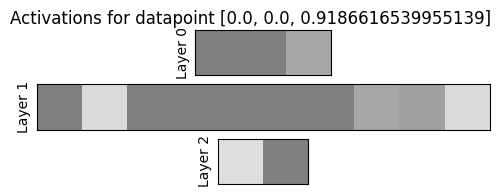

    [Layer 0] [0.7613928  1.1504579  0.06431386]
    [Layer 1] [ 0.          0.58703136  2.7523584   0.          0.         -0.04391358
  0.         -1.2749661  -0.04145338 -0.00289237]
    [Layer 2] [0.        2.3514547]


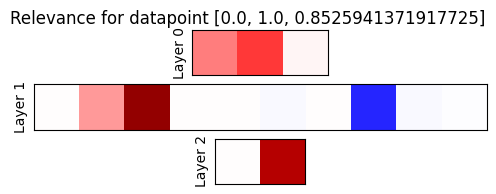

    [Layer 0] [0.7613928  1.1504579  0.06431386]
    [Layer 1] [ 0.          0.58703136  2.7523584   0.          0.         -0.04391358
  0.         -1.2749661  -0.04145338 -0.00289237]
    [Layer 2] [0.        2.3514547]


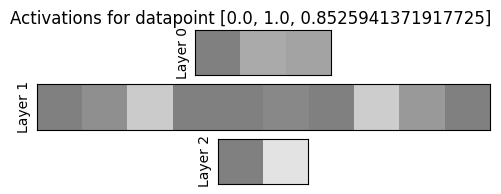

    [Layer 0] [-0.5977299   2.0029855   0.38255244]
    [Layer 1] [ 0.          3.087075    0.          0.          0.         -0.01724833
  0.         -1.238458   -0.04036307 -0.00319764]
    [Layer 2] [0.       2.159576]


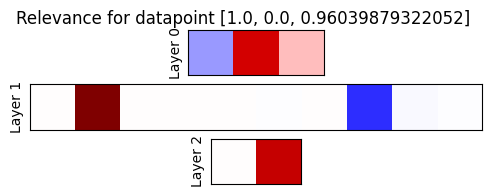

    [Layer 0] [-0.5977299   2.0029855   0.38255244]
    [Layer 1] [ 0.          3.087075    0.          0.          0.         -0.01724833
  0.         -1.238458   -0.04036307 -0.00319764]
    [Layer 2] [0.       2.159576]


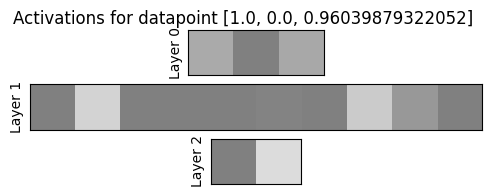

    [Layer 0] [0.7350928  0.8062046  0.22131751]
    [Layer 1] [-6.2330480e-04 -0.0000000e+00 -8.6793746e-04 -0.0000000e+00
 -0.0000000e+00 -5.5545671e-03  0.0000000e+00  1.7950737e+00
 -2.5412951e-02  0.0000000e+00]
    [Layer 2] [1.9863712 0.       ]


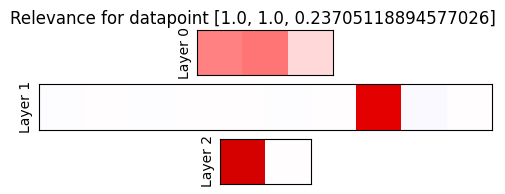

    [Layer 0] [0.7350928  0.8062046  0.22131751]
    [Layer 1] [-6.2330480e-04 -0.0000000e+00 -8.6793746e-04 -0.0000000e+00
 -0.0000000e+00 -5.5545671e-03  0.0000000e+00  1.7950737e+00
 -2.5412951e-02  0.0000000e+00]
    [Layer 2] [1.9863712 0.       ]


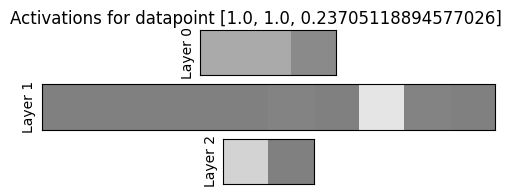

In [16]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

for i in range(8):
    #print(f"[POINT] {data[i].tolist()}")

    # -- Display relevance --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(R[l][i].reshape((1, len(R[l][i]))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Relevance for datapoint {X[i].tolist()}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        axs[l].imshow(A[l][i].reshape((1, len(A[l][i]))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] {R[l][i]}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Activations for datapoint {X[i].tolist()}")
    plt.show()

### Average relevance
#### Entire dataset

    [Layer 0] R: [0.7498461  1.1226616  0.02713289]
    [Layer 1] R: [ 0.00580273  0.17470413  0.69437665  0.          0.         -0.00730959
  0.          0.0198395  -0.05092482  1.0631521 ]
    [Layer 2] R: [1.0578187 1.1359355]


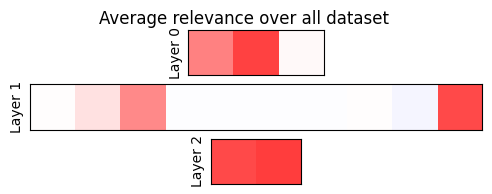

    [Layer 0] A: [0.5        0.5        0.47840136]
    [Layer 1] A: [0.03011098 1.036599   0.44152793 0.         0.         0.07146849
 0.         1.597253   0.36939088 0.531364  ]
    [Layer 2] A: [1.0578187 1.1359355]


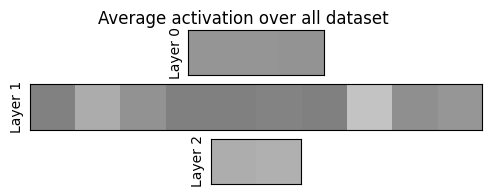

In [22]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    relevance = np.mean(R[l], axis=0)

    axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] R: {relevance}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average relevance over all dataset")
plt.show()

# -- Display activations --
fig, axs = plt.subplots(L+1, 1)
b = 3
for l in range(L+1):
    activation = np.mean(A[l], axis=0)

    axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
    axs[l].figure.set_size_inches(10, 2)
    print(f"    [Layer {l}] A: {activation}")
    axs[l].set_xticks([])
    axs[l].set_yticks([])
    axs[l].set_ylabel(f"Layer {l}")

fig.suptitle(f"Average activation over all dataset")
plt.show()

#### Grouped by class

    [Layer 0] R: [ 2.0585206   0.43159914 -0.38395634]
    [Layer 1] R: [ 0.0000000e+00 -2.5193462e+00 -1.1224928e-03  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  4.7324452e-01
 -1.0089518e-01  4.2542830e+00]
    [Layer 2] R: [2.3073747 0.       ]


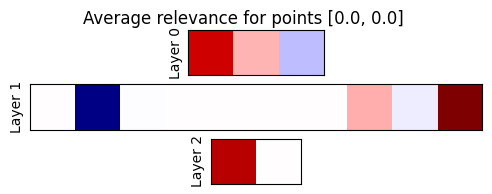

    [Layer 0] A: [0.         0.         0.48760733]
    [Layer 1] A: [0.0000000e+00 2.0092428e+00 9.3654339e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 7.0099199e-01 5.0553852e-01 2.1246462e+00]
    [Layer 2] A: [2.3073747 0.       ]


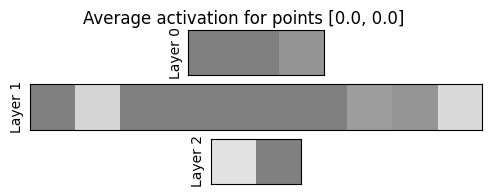

    [Layer 0] R: [0.7614368  1.2274215  0.02362874]
    [Layer 1] R: [ 2.3736523e-02  4.0119013e-01  2.7795358e+00  0.0000000e+00
  0.0000000e+00 -1.5336479e-02  0.0000000e+00 -1.1490604e+00
 -2.6783893e-02 -7.9480803e-04]
    [Layer 2] R: [0.        2.3914967]


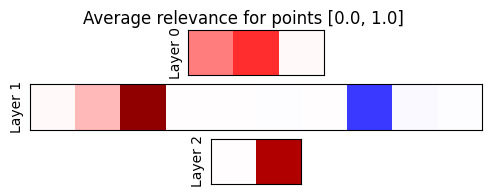

    [Layer 0] A: [0.         1.         0.43767792]
    [Layer 1] A: [1.0429671e-01 2.4864502e-01 1.7644886e+00 0.0000000e+00 0.0000000e+00
 6.7506887e-02 0.0000000e+00 1.6210678e+00 3.8123244e-01 3.8245917e-04]
    [Layer 2] A: [0.        2.3914967]


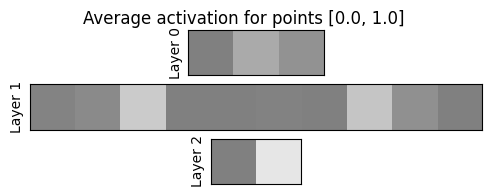

    [Layer 0] R: [-0.56102026  2.0201993   0.31841338]
    [Layer 1] R: [ 0.0000000e+00  2.9098151e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -3.8829229e-03  0.0000000e+00 -1.1026157e+00
 -2.4843464e-02 -8.8046939e-04]
    [Layer 2] R: [0.        2.1522467]


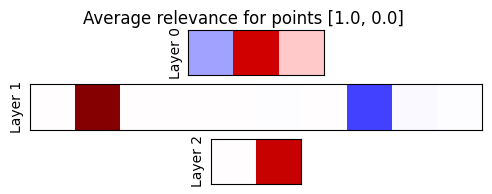

    [Layer 0] A: [1.         0.         0.51902163]
    [Layer 1] A: [0.0000000e+00 1.8206184e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 1.7280065e-02 0.0000000e+00 1.5733899e+00 3.5749638e-01 4.2760372e-04]
    [Layer 2] A: [0.        2.1522467]


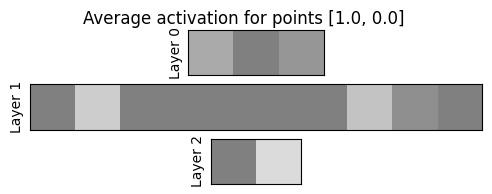

    [Layer 0] R: [0.74044746 0.8114265  0.15044574]
    [Layer 1] R: [-5.2561919e-04 -9.2841893e-02 -9.0655981e-04  0.0000000e+00
  0.0000000e+00 -1.0018978e-02  0.0000000e+00  1.8577894e+00
 -5.1176686e-02  0.0000000e+00]
    [Layer 2] R: [1.9238997 0.       ]


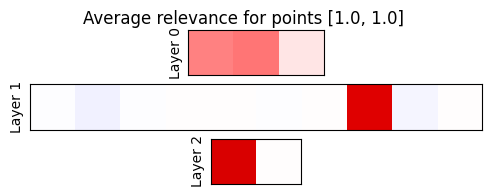

    [Layer 0] A: [1.         1.         0.46929818]
    [Layer 1] A: [1.6147215e-02 6.7890331e-02 6.8681885e-04 0.0000000e+00 0.0000000e+00
 2.0108700e-01 0.0000000e+00 2.4935622e+00 2.3329599e-01 0.0000000e+00]
    [Layer 2] A: [1.9238997 0.       ]


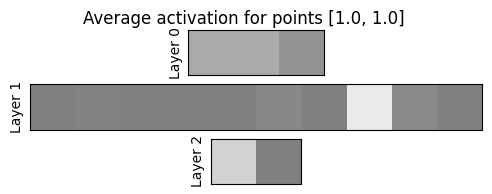

In [26]:
cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
cmap = ListedColormap(cmap)

# -- Display relevance --
for i in range(4):
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        relevance = np.mean(R[l][i::4], axis=0)

        axs[l].imshow(relevance.reshape((1, len(relevance))), cmap=cmap, interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] R: {relevance}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    point = X[i].tolist()
    point.pop() # remove useless feature from display

    fig.suptitle(f"Average relevance for points {point}")
    plt.show()

    # -- Display activations --
    fig, axs = plt.subplots(L+1, 1)
    b = 3
    for l in range(L+1):
        activation = np.mean(A[l][i::4], axis=0)

        axs[l].imshow(activation.reshape((1, len(activation))), cmap="gray", interpolation='nearest', vmin=-b,vmax=b)
        axs[l].figure.set_size_inches(10, 2)
        print(f"    [Layer {l}] A: {activation}")
        axs[l].set_xticks([])
        axs[l].set_yticks([])
        axs[l].set_ylabel(f"Layer {l}")

    fig.suptitle(f"Average activation for points {point}")
    plt.show()